In [1]:
!pip install yfinance tensorflow pandas numpy matplotlib scikit-learn ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=bba5b2ebfc2c8eda4cef55377ce436dcecb2f89ef697525ba81fe1e27578bd23
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import ta
import os

In [9]:
df = yf.download(ticker, start=start_date, end=end_date)

# FIX: Flatten MultiIndex columns
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(0)

df.head()

/tmp/ipython-input-2319968177.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,24.214895,24.682228,23.776355,24.671153,212818400
2015-01-05,23.532721,24.064284,23.346674,23.984549,257142000
2015-01-06,23.534935,23.794071,23.173914,23.596950,263188400
2015-01-07,23.864944,23.964612,23.632385,23.743127,160423600
2015-01-08,24.781889,24.839475,24.075353,24.192741,237458000


In [10]:
# Moving Averages
df.columns = df.columns.droplevel(0) # Flatten MultiIndex columns
df["MA_20"] = df["Close"].rolling(window=20).mean()
df["MA_50"] = df["Close"].rolling(window=50).mean()

# RSI Indicator
df["RSI"] = ta.momentum.RSIIndicator(df["Close"], window=14).rsi()

# Remove missing values
df.dropna(inplace=True)

df.tail()

Price,Close,High,Low,Open,Volume,MA_20,MA_50,RSI
Date,,,,,,,,
2024-12-24,256.797211,256.807136,253.903002,254.101927,23234700,244.955383,234.541782,75.750279
2024-12-26,257.612732,258.686881,256.230300,256.787255,27237100,246.146873,235.047559,76.452880
2024-12-27,254.201355,257.294474,251.685102,256.429175,42355300,247.174261,235.526238,67.626227
2024-12-30,250.829773,252.122713,249.387654,250.859609,35557500,247.913721,235.930134,60.225547
2024-12-31,249.059464,251.903926,248.074837,251.068493,39480700,248.452279,236.241995,56.715915


In [11]:
features = ["Close", "MA_20", "MA_50", "RSI"]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[features])

scaled_data.shape

(2467, 4)

In [12]:
def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 0])  # Close price
    return np.array(X), np.array(y)

TIME_STEPS = 60

X, y = create_sequences(scaled_data, TIME_STEPS)

X.shape, y.shape

((2407, 60, 4), (2407,))

In [13]:
split = int(0.8 * len(X))

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train.shape, X_test.shape

((1925, 60, 4), (482, 60, 4))

In [14]:
model = Sequential()

model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(
    optimizer="adam",
    loss="mean_squared_error"
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,753 (198.25 KB)

 Trainable params: 50,753 (198.25 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.0187 - val_loss: 0.0013
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0011 - val_loss: 9.8649e-04
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 8.3644e-04 - val_loss: 8.9517e-04
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 8.6491e-04 - val_loss: 7.6526e-04
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 7.0814e-04 - val_loss: 7.3091e-04
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 7.2318e-04 - val_loss: 9.8728e-04
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 6.3452e-04 - val_loss: 7.0785e-04
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 7.7756e-04 - val_loss: 0.0021
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - loss: 9.4722e-04 - val_loss: 8.1425e-04
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 8.1294e-04 - val_loss: 6.3275e-04
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.5209e-04 - val_loss: 0.

In [16]:
predictions = model.predict(X_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [17]:
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0]

y_test_inv = close_scaler.inverse_transform(y_test.reshape(-1, 1))
pred_inv = close_scaler.inverse_transform(predictions)

In [18]:
rmse = np.sqrt(mean_squared_error(y_test_inv, pred_inv))
rmse

np.float64(7.124699084591412)

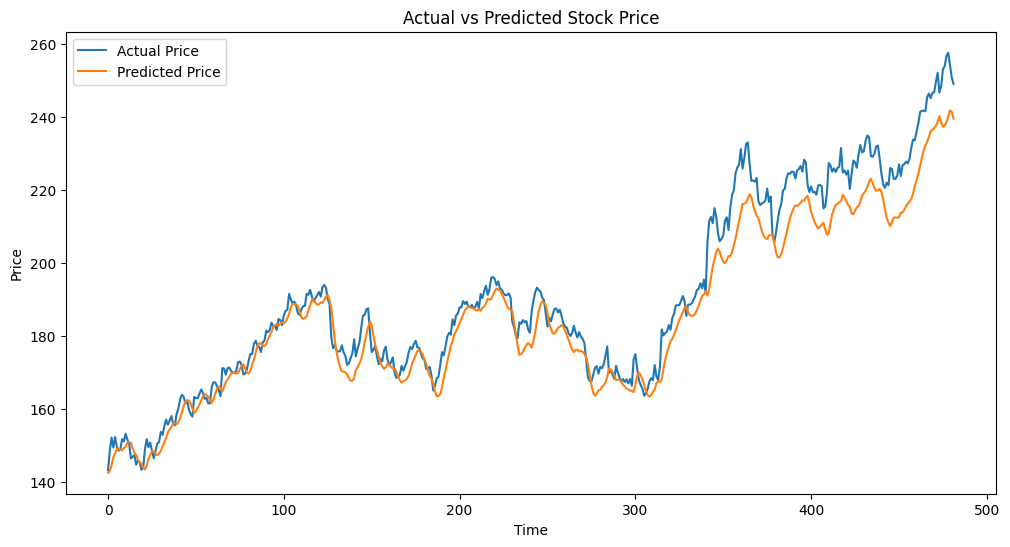

In [19]:
os.makedirs("graphs", exist_ok=True)

plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual Price")
plt.plot(pred_inv, label="Predicted Price")
plt.title("Actual vs Predicted Stock Price")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.savefig("graphs/actual_vs_predicted.png")
plt.show()

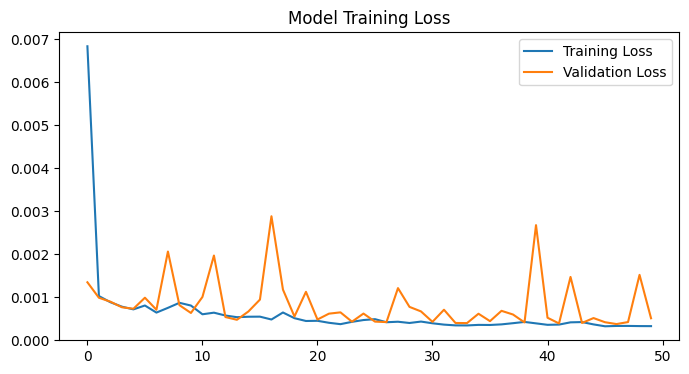

In [20]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Training Loss")
plt.legend()
plt.savefig("graphs/training_loss.png")
plt.show()

In [21]:
model.save("lstm_stock_model.h5")